In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import altair as alt
import geopandas as gpd

In [2]:
################################################# Data
##read data
#df_all = pd.read_csv(r'pp-complete.csv',header=None)
df20 = pd.read_csv(r'pp-2020.csv',header=None)
df19 = pd.read_csv(r'pp-2019.csv',header=None)
df18 = pd.read_csv(r'pp-2018.csv',header=None)
frames = [df20,df19,df18]
df_all = pd.concat(frames) 
df_sub = df_all.drop(columns=[3,4,5,6,7,8,9,14,15])
names = ['ID','Price','Date','Locality',
         'Town/City','District','County']
numbs = [0,1,2,10,11,12,13]
maps_ = dict(zip(numbs,names))
df_sub.rename(columns=maps_,inplace=True)
df_sub.isnull().sum()
df_sub.set_index('ID',inplace=True)
df_sub.Date = pd.to_datetime(df_sub.Date) 
df_sub['Year'] = df_sub.Date.dt.year
df_sub['Month'] = df_sub.Date.dt.month
################################################# END Data

C:\Users\ppaykari\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\ppaykari\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


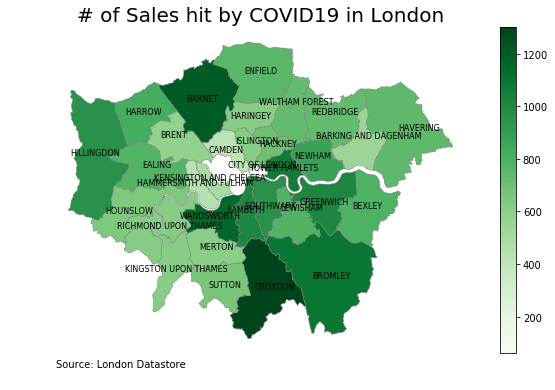

In [3]:
################################################# Plot 2
##map data
path = r'statistical-gis-boundaries-london\ESRI'
map_ = r'\London_Borough_Excluding_MHW.shp'
df_map = gpd.read_file(path+map_)
cols_to_drop = ['GSS_CODE','HECTARES',
                'NONLD_AREA','ONS_INNER',
                'SUB_2009','SUB_2006']
df_map.drop(columns=cols_to_drop,inplace=True)
df_map['NAME'] = df_map['NAME'].str.upper()
#df_map.head(1)
#df_map.plot()

##house price data
cols_to_drop = ['Locality','Town/City','County']
df_lon = df_sub[df_sub.County=='GREATER LONDON']
df_lon.drop(columns=cols_to_drop,inplace=True)
df_lon = df_lon[(df_lon.Month<6) & (df_lon.Year>2018)]
df_grp = df_lon.groupby(['Year','District'])['Date'].count()
df_grp = pd.DataFrame(df_grp).reset_index()
df_grp.rename(columns={'Date':'Count'},inplace=True)
df_piv = df_grp.pivot(index='District',columns='Year',values='Count')
df_piv['Drop in # of Sales'] = df_piv[2019]-df_piv[2020]
df_piv.drop(columns=[2019,2020],inplace=True)

df_mer = df_map.merge(df_piv,left_on='NAME',right_on='District')
df_mer['coords'] = df_mer['geometry'].apply(lambda x: x.representative_point().coords[:])
df_mer['coords'] = [coords[0] for coords in df_mer['coords']]
noise = np.random.uniform(0,1000,32)
df_mer['coords_jitter'] = df_mer['coords']
names = ['HAVERING',
         'LEWISHAM',
         'WALTHAM FOREST', 
         'REDBRIDGE',
         'KENSINGTON AND CHELSEA','TOWER HAMLETS',
         'ISLINGTON',
         'CITY OF LONDON']
for i in names:
    ind = df_mer[df_mer.NAME==i].index
    df_mer['coords_jitter'][ind] = df_mer['coords'][ind] + noise[ind]

##map plot
col_ = 'Drop in # of Sales'
min_ = 1300
max_ = 60

fig,ax = plt.subplots(1,figsize=(10,6))
df_mer.plot(column=col_,cmap='Greens',
            linewidth=0.5,ax=ax,edgecolor='0.5')
for idx,row in df_mer.iterrows():
    plt.annotate(s=row['NAME'],
                 xy=row['coords_jitter'],
                 horizontalalignment='center',
                 fontsize=8)
ax.axis('off')
ax.set_title('# of Sales hit by COVID19 in London', 
fontdict={'fontsize':'20','fontweight':'2'})
ax.annotate('Source: London Datastore',
xy=(0.1, .08),xycoords='figure fraction', 
horizontalalignment='left', verticalalignment='top')
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Greens',
     norm=plt.Normalize(vmin=min_,vmax=max_))
sm._A = []
cbar = fig.colorbar(sm)
fig.savefig('map_London3.png',dpi=100)
################################################# END Plot 2

In [4]:

################################################# Plot 1
df1 = df_sub.groupby(['Year','Month'])['Price'].agg(['mean','count'])
df1.reset_index(inplace=True)
df1.rename(columns={'mean':'Average House Price (£)','count':'# of Sales'},inplace=True)
df2 = df1[(df1.Month<6) & (df1.Year>2015)]
df2 = df2.assign(date=pd.to_datetime(df2[['Year','Month']].assign(day=1)))
df2['Average House Price (£)'] = df2['Average House Price (£)'].round(decimals=-3)
#df2['Average House Price (£)'] = df2['Average House Price (£)'].apply(lambda x: "£{:.0f}k".format((x/1000)))
##Regularisation step to decrease gap between elements
reg_coef = 1e4
df2['# of Sales Regularised'] = (reg_coef+df2['# of Sales'])/reg_coef

##plot interactive 
selection = alt.selection_single(
    name='select',fields=['Year'],on='mouseover'
    )
chart = alt.Chart(df2).mark_point(filled=True).encode(
    alt.X('month(date):N'),
    alt.Y('Average House Price (£)',scale=alt.Scale(zero=False)),
    alt.Size('# of Sales Regularised:Q'),
    alt.OpacityValue(0.8),
    alt.Order('# of Sales:Q', sort='ascending'),
    tooltip = [alt.Tooltip('# of Sales:Q'),
               alt.Tooltip('Average House Price (£):Q'),
               alt.Tooltip('Year:Q')
              ],
    color=alt.condition(selection,'Year:N',alt.value('grey'))
).add_selection(selection).properties(
    width=500,
    height=300
)
chart
chart.save('chart.html')
chart.save('chart.json')
################################################# END Plot 1


In [5]:
chart

alt.Chart(...)